Connected to .venv (Python 3.11.4)

In [1]:
import numpy as np

from estimators.volt_funcs import Volterra
from estimators.volt2_funcs import Volterra2
from estimators.volt_lasso_funcs import VolterraFeatureLasso
from estimators.volt_lasso_funcs2 import VolterraLasso
from estimators.ngrc_funcs import NGRC
from estimators.sindy_funcs import SINDyPolynomialSTLSQ

from datagen.data_generate import rk45
from utils.normalisation import normalise_arrays
from utils.plotting import plot_data, plot_data_distributions
from utils.errors import calculate_mse

In [2]:
# Define a sample training data
data_len = 100
data = np.linspace(0, data_len-1, data_len).reshape((-1, 2))

# Define full data training and testing sizes
ndata  = len(data)
ntrain = 25
washout = 10
ntest = ndata - ntrain

# Construct training input and teacher, testing input and teacher
training_input = data[0:ntrain-1] 
training_teacher = data[1:ntrain]
testing_input= data[ntrain-1:ntrain+ntest-1]
testing_teacher = data[ntrain:ntrain+ntest]

ld_coef = 0.8
tau_coef = 0.2
reg = 1e-10

In [3]:
# Create the Lorenz dataset
def lorenz(t, Z, args):
    u, v, w = Z
    sig, beta, rho = args
    
    up = -sig*(u - v)
    vp = rho*u - v - u*w
    wp = -beta*w + u*v
    
    return np.array([up, vp, wp])

lor_args = (10, 8/3, 28)
Z0 = (0, 1, 1.05)

h = 0.005
t_span = (0, 40)
slicing = int(h/h)

t_eval, data = rk45(lorenz, t_span, Z0, h, lor_args)
t_eval = t_eval[::slicing]
data = data[::slicing]

# Define full data training and testing sizes
ndata  = len(data)
ntrain = 5000 
washout = 1000
ntest = ndata - ntrain

# Construct training input and teacher, testing input and teacher
training_input_orig = data[0:ntrain-1] 
training_teacher_orig = data[1:ntrain]
testing_input_orig = data[ntrain-1:ntrain+ntest-1]
testing_teacher_orig = data[ntrain:ntrain+ntest]

# Normalise the arrays for Volterra
normalisation_output = normalise_arrays([training_input_orig, training_teacher_orig, testing_input_orig, testing_teacher_orig], norm_type="ScaleL2Shift")
training_input, training_teacher, testing_input, testing_teacher = normalisation_output[0]
shift, scale = normalisation_output[1], normalisation_output[2]

ld_coef = 0.8
tau_coef = 0.2
reg = 1e-10

In [4]:
volt = Volterra(ld_coef, tau_coef, reg, washout, regression="L2")
volt.Train(training_input, training_teacher)
output = volt.Forecast(testing_input)
pathcont = volt.PathContinue(training_teacher[-1], testing_teacher.shape[0])

volt2 = Volterra2(ld_coef, tau_coef, reg, washout)
volt2.Train(training_input, training_teacher)
output2 = volt2.Forecast(testing_input)
pathcont2 = volt2.PathContinue(training_teacher[-1], testing_teacher.shape[0])

print(np.allclose(output, output2))
print(np.allclose(pathcont, pathcont2))

True
True


True
True
2.4615511150371753e-09
26.843773404648903


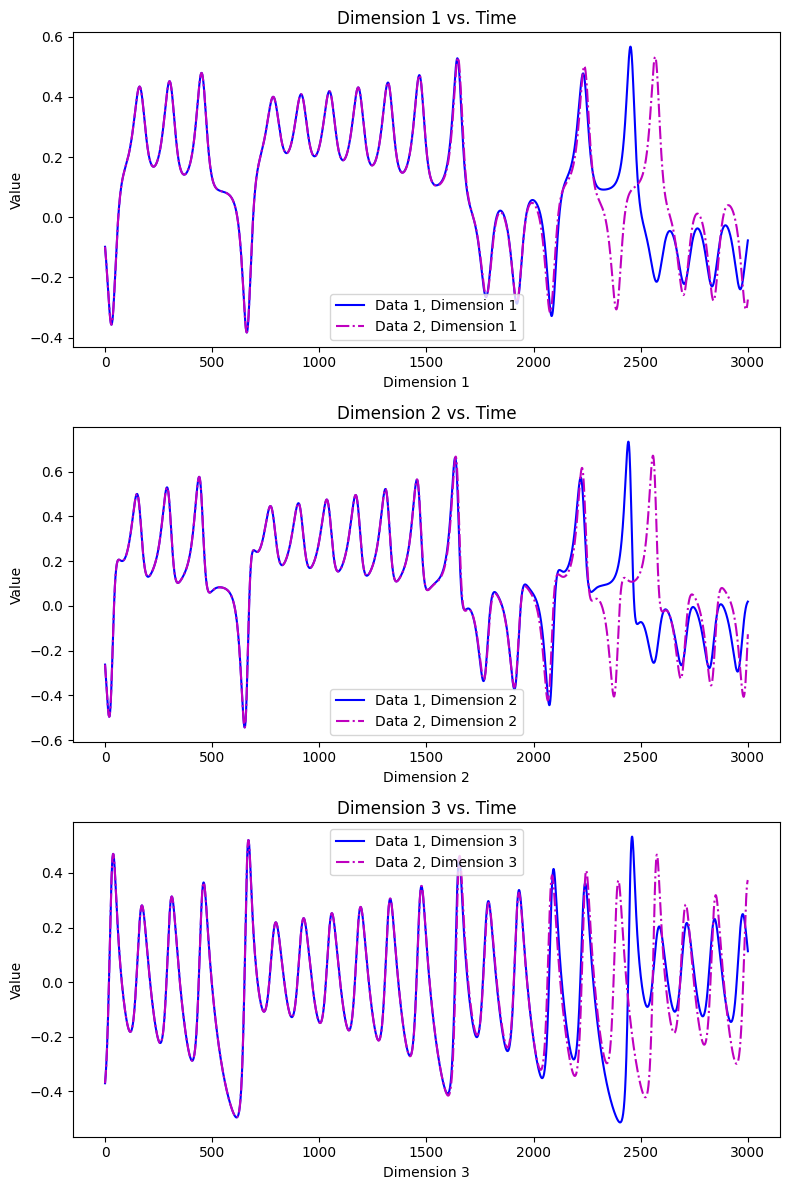

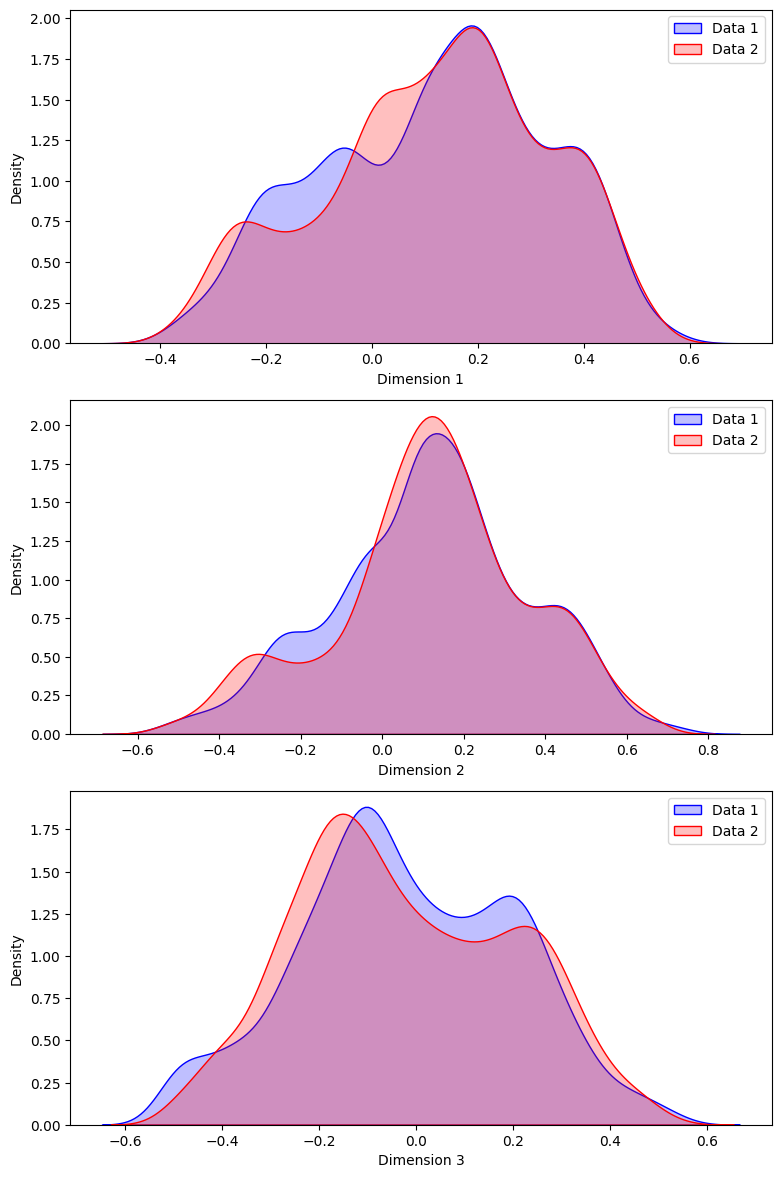

In [5]:
volt = Volterra(ld_coef, tau_coef, reg, washout, regression="L2", pinv=True)
volt.Train(training_input, training_teacher)
output = volt.Forecast(testing_input)
pathcont = volt.PathContinue(training_teacher[-1], testing_teacher.shape[0])

volt2 = Volterra2(ld_coef, tau_coef, reg, washout, pinv=True)
volt2.Train(training_input, training_teacher)
output2 = volt2.Forecast(testing_input)
pathcont2 = volt2.PathContinue(training_teacher[-1], testing_teacher.shape[0])

print(np.allclose(output, output2))
print(np.allclose(pathcont, pathcont2))

print(calculate_mse(testing_teacher, output2, shift, scale))
print(calculate_mse(testing_teacher, pathcont2, shift, scale))

plot_data([testing_teacher, pathcont2])
plot_data_distributions([testing_teacher, pathcont2])

0.4276688560471563
122.44580654757559


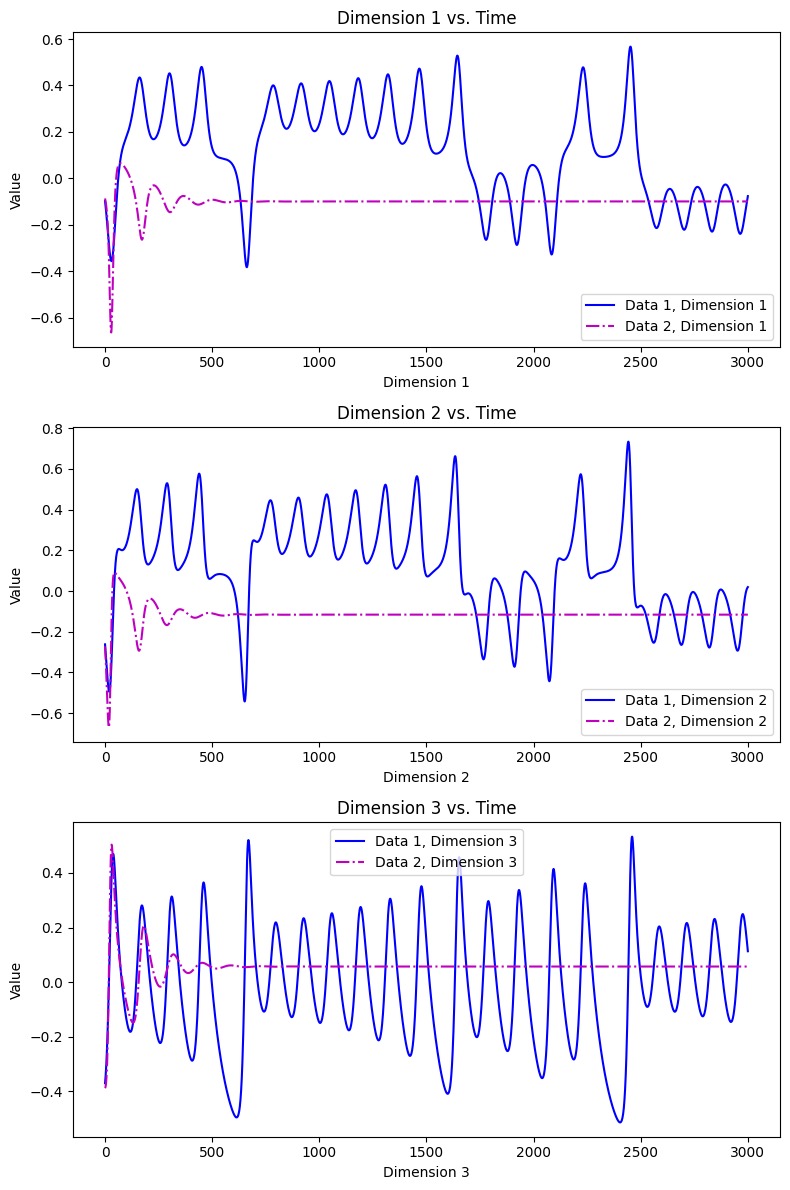

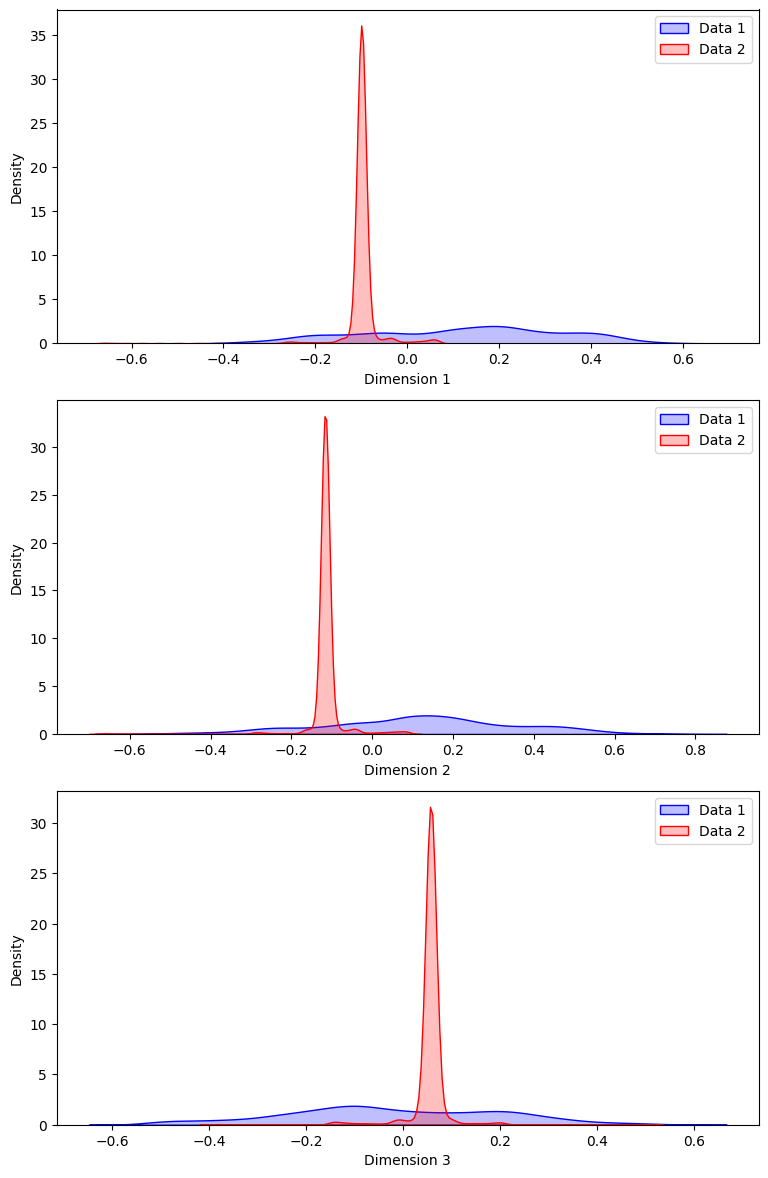

In [6]:
volt2 = Volterra2(ld_coef, tau_coef, reg, washout, nfeatures=28)
volt2.Train(training_input, training_teacher)
output2 = volt2.Forecast(testing_input)
pathcont2 = volt2.PathContinue(training_teacher[-1], testing_teacher.shape[0])

print(calculate_mse(testing_teacher, output2, shift, scale))
print(calculate_mse(testing_teacher, pathcont2, shift, scale))

plot_data([testing_teacher, pathcont2])
plot_data_distributions([testing_teacher, pathcont2])

In [7]:
volt = Volterra(ld_coef, tau_coef, reg, washout, regression="L2")
volt.Train(training_input, training_teacher)
output = volt.Forecast(testing_input)
pathcont = volt.PathContinue(training_teacher[-1], testing_teacher.shape[0])

volt2 = Volterra2(ld_coef, tau_coef, reg, washout, nfeatures=3999)
volt2.Train(training_input, training_teacher)
output2 = volt2.Forecast(testing_input)
pathcont2 = volt2.PathContinue(training_teacher[-1], testing_teacher.shape[0])

print(np.allclose(output, output2))
print(np.allclose(pathcont, pathcont2))
#### Different because of the inverse computation

False
False


In [8]:
voltlasso = Volterra(ld_coef, tau_coef, reg, washout, regression="Lasso")
voltlasso.Train(training_input, training_teacher)
output = voltlasso.Forecast(testing_input)
pathcont = voltlasso.PathContinue(training_teacher[-1], testing_teacher.shape[0])

voltlasso2 = VolterraLasso(ld_coef, tau_coef, reg, washout)
voltlasso2.Train(training_input, training_teacher)
output2 = voltlasso2.Forecast(testing_input)
pathcont2 = voltlasso2.PathContinue(training_teacher[-1], testing_teacher.shape[0])

print(np.allclose(output, output2))
print(np.allclose(pathcont, pathcont2))

True
True


In [10]:
reg_range = np.logspace(-10, -7, 4)
voltlasso = VolterraFeatureLasso(ld_coef, tau_coef, washout, 28, reg_range)
voltlasso.Train(training_input, training_teacher)
output = voltlasso.Forecast(testing_input)
pathcont = voltlasso.PathContinue(training_teacher[-1], testing_teacher.shape[0])

voltlasso2 = VolterraLasso(ld_coef, tau_coef, reg_range, washout, 28)
voltlasso2.Train(training_input, training_teacher)
output2 = voltlasso2.Forecast(testing_input)
pathcont2 = voltlasso2.PathContinue(training_teacher[-1], testing_teacher.shape[0])

print(np.allclose(output, output2))
print(np.allclose(pathcont, pathcont2))

print(voltlasso.nfeatures_seen)
print(voltlasso2.nfeatures)

True
True
[1714. 3087. 2997.]
[1714. 3087. 2997.]


In [11]:
voltlasso1 = VolterraLasso(ld_coef, tau_coef, 1e-15, washout).Train(training_input, training_teacher)
voltlasso2 = VolterraLasso(ld_coef, tau_coef, [1e-15, 1e-16, 1e-9], washout).Train(training_input, training_teacher)
voltlasso3 = VolterraLasso(ld_coef, tau_coef, np.array([1e-15, 1e-16, 1e-9]), washout).Train(training_input, training_teacher)

print(vars(voltlasso1))
print(vars(voltlasso2))
print(vars(voltlasso3))

{'ld_coef': 0.8, 'tau_coef': 0.2, 'reg': [1e-15, 1e-15, 1e-15], 'washout': 1000, 'nfeatures': array([3999., 3999., 3999.]), 'max_iter': 1000, 'tol': 0.0001, 'Gram': array([[2.62007662, 2.62009877, 2.6201214 , ..., 2.60742614, 2.60705207,
        2.60664259],
       [2.62009877, 2.63681079, 2.6368476 , ..., 2.61635964, 2.61577161,
        2.61512742],
       [2.6201214 , 2.6368476 , 2.64731129, ..., 2.62201945, 2.62130878,
        2.62052977],
       ...,
       [2.60742614, 2.61635964, 2.62201945, ..., 2.62765964, 2.6278012 ,
        2.62791182],
       [2.60705207, 2.61577161, 2.62130878, ..., 2.6278012 , 2.62798133,
        2.62813232],
       [2.60664259, 2.61512742, 2.62052977, ..., 2.62791182, 2.62813232,
        2.62832563]]), 'training_input': array([[ 0.08887119,  0.11592774, -0.62523707],
       [ 0.09015494,  0.1158834 , -0.62560043],
       [ 0.0913781 ,  0.1160078 , -0.62595275],
       ...,
       [-0.06768974, -0.20745809, -0.39795852],
       [-0.07486002, -0.22052699, -

In [12]:
voltlasso1 = VolterraLasso(ld_coef, tau_coef, np.logspace(-10, -7, 4), washout, 28).Train(training_input, training_teacher)
voltlasso2 = VolterraLasso(ld_coef, tau_coef, [np.logspace(-10, -7, 4), np.array([1e-4, 1e-2]), np.linspace(0.01, 0.1, 2)], washout, 28).Train(training_input, training_teacher)
voltlasso3 = VolterraLasso(ld_coef, tau_coef, np.logspace(-10, -7, 4), washout, [28, 40, 50]).Train(training_input, training_teacher)
voltlasso4 = VolterraLasso(ld_coef, tau_coef, [np.logspace(-10, -7, 4), np.array([1e-15, 1e-5, 1e-6]), np.linspace(0.01, 0.1, 2)], washout, [28, 40, 50]).Train(training_input, training_teacher)

print(vars(voltlasso1))
print(vars(voltlasso2))
print(vars(voltlasso3))
print(vars(voltlasso4))

{'ld_coef': 0.8, 'tau_coef': 0.2, 'reg': [array([1.e-10, 1.e-09, 1.e-08, 1.e-07]), array([1.e-10, 1.e-09, 1.e-08, 1.e-07]), array([1.e-10, 1.e-09, 1.e-08, 1.e-07])], 'washout': 1000, 'nfeatures': array([1714., 3087., 2997.]), 'max_iter': 1000, 'tol': 0.0001, 'Gram': array([[2.62007662, 2.62009877, 2.6201214 , ..., 2.60742614, 2.60705207,
        2.60664259],
       [2.62009877, 2.63681079, 2.6368476 , ..., 2.61635964, 2.61577161,
        2.61512742],
       [2.6201214 , 2.6368476 , 2.64731129, ..., 2.62201945, 2.62130878,
        2.62052977],
       ...,
       [2.60742614, 2.61635964, 2.62201945, ..., 2.62765964, 2.6278012 ,
        2.62791182],
       [2.60705207, 2.61577161, 2.62130878, ..., 2.6278012 , 2.62798133,
        2.62813232],
       [2.60664259, 2.61512742, 2.62052977, ..., 2.62791182, 2.62813232,
        2.62832563]]), 'training_input': array([[ 0.08887119,  0.11592774, -0.62523707],
       [ 0.09015494,  0.1158834 , -0.62560043],
       [ 0.0913781 ,  0.1160078 , -0.6259

3
71.81854566420361


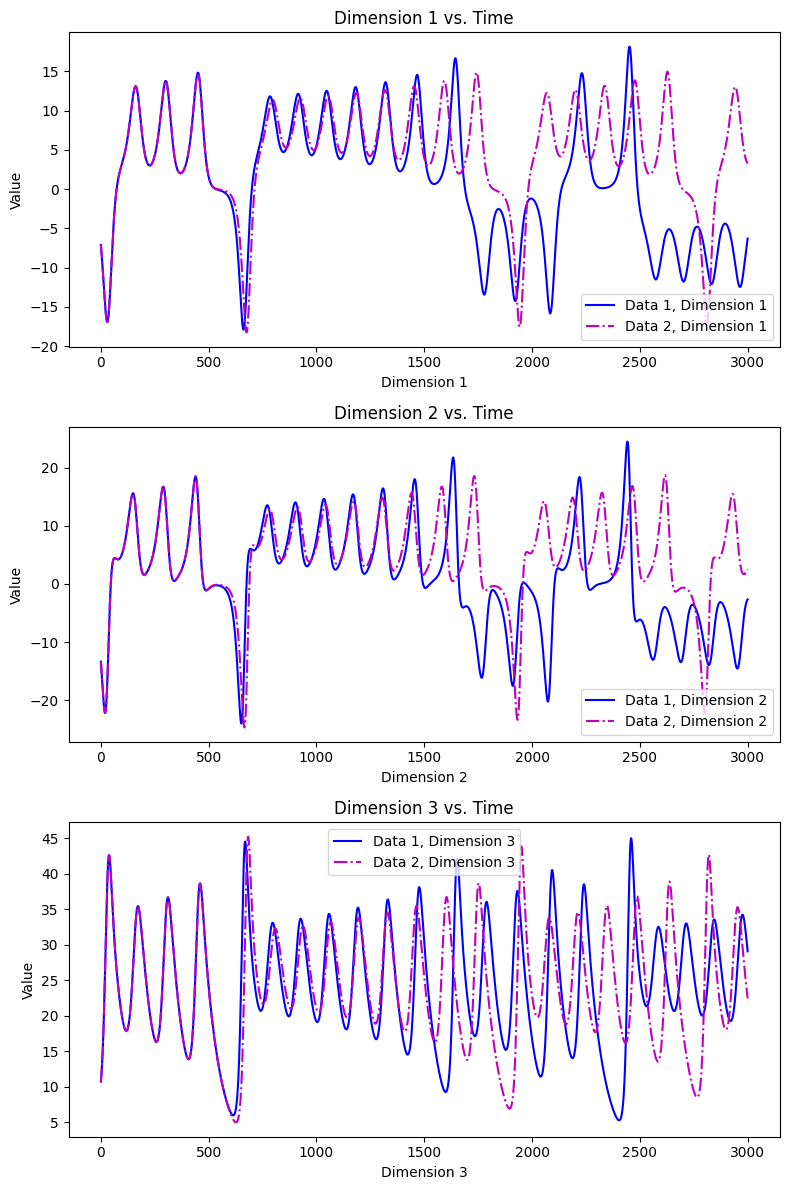

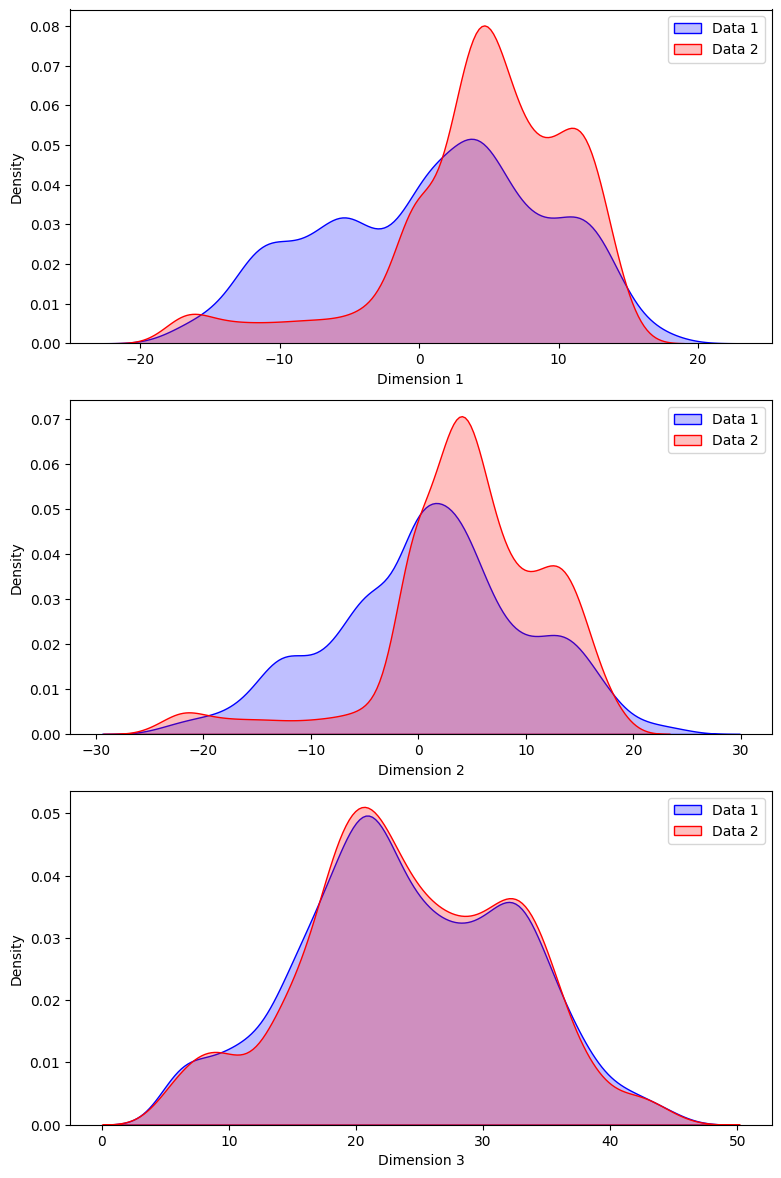

In [13]:
normalisation_output = normalise_arrays([training_input_orig, training_teacher_orig, testing_input_orig, testing_teacher_orig], norm_type=None)
training_input, training_teacher, testing_input, testing_teacher = normalisation_output[0]
shift, scale = normalisation_output[1], normalisation_output[2]

ngrc = NGRC(2, 2, 1e-4, washout)
ngrc.Train(training_input, training_teacher)
pathcontngrc = ngrc.PathContinue(training_teacher[-1], testing_teacher.shape[0])

print(calculate_mse(testing_teacher, pathcontngrc, shift, scale))

plot_data([testing_teacher, pathcontngrc])
plot_data_distributions([testing_teacher, pathcontngrc])

62.45528888370892


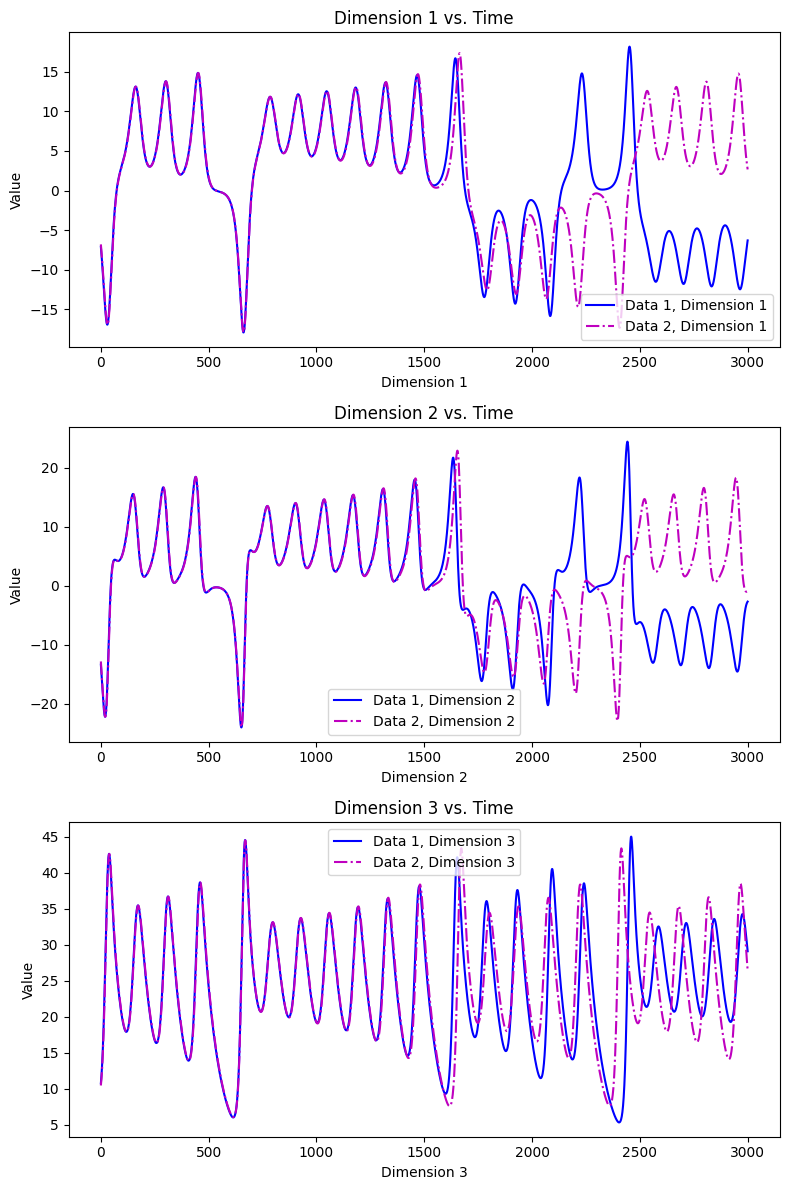

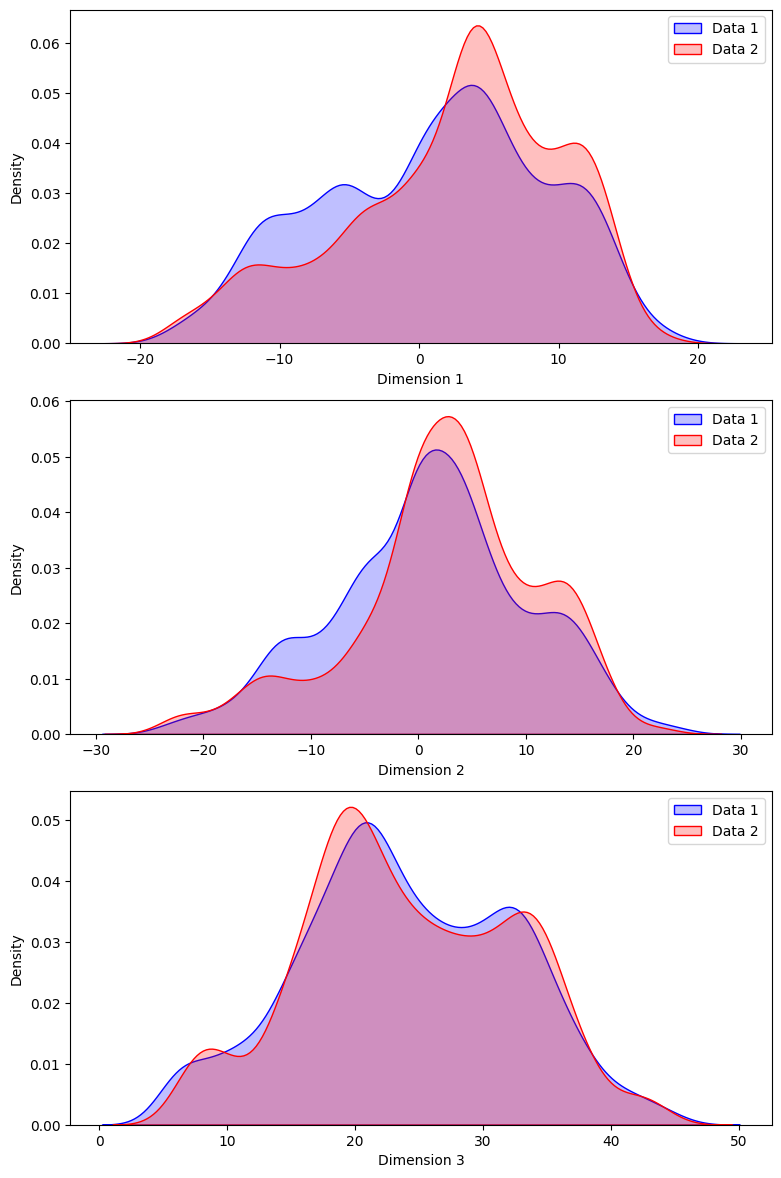

In [14]:
normalisation_output = normalise_arrays([training_input_orig, training_teacher_orig, testing_input_orig, testing_teacher_orig], norm_type=None)
training_input, training_teacher, testing_input, testing_teacher = normalisation_output[0]
shift, scale = normalisation_output[1], normalisation_output[2]

threshold, alpha, deg = 0.1, 1e-15, 2

sindy = SINDyPolynomialSTLSQ(1e-15, 0.1, 2, 0.005)
sindy.Train(training_input, training_teacher)
pathcontsindy = sindy.PathContinue(training_teacher[-1], testing_teacher.shape[0])

print(calculate_mse(testing_teacher, pathcontsindy, shift, scale))

plot_data([testing_teacher, pathcontsindy])
plot_data_distributions([testing_teacher, pathcontsindy])